<a href="https://colab.research.google.com/github/Tigeronsky/training-material/blob/main/chapter03_introduction-to-keras-and-tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

# Introduction to Keras and TensorFlow

## What's TensorFlow?

## What's Keras?

## Keras and TensorFlow: A brief history

## Setting up a deep-learning workspace

### Jupyter notebooks: The preferred way to run deep-learning experiments

### Using Colaboratory

#### First steps with Colaboratory

#### Installing packages with pip

#### Using the GPU runtime

## First steps with TensorFlow

#### Constant tensors and variables

**All-ones or all-zeros tensors**

In [ ]:
import tensorflow as tf
x = tf.ones(shape=(2, 1))
print(x)

In [ ]:
x = tf.zeros(shape=(2, 1))
print(x)

**Random tensors**

In [ ]:
x = tf.random.normal(shape=(3, 1), mean=0., stddev=1.)
print(x)

In [ ]:
x = tf.random.uniform(shape=(3, 1), minval=0., maxval=1.)
print(x)

**NumPy arrays are assignable**

In [ ]:
import numpy as np
x = np.ones(shape=(2, 2))
x[0, 0] = 0.

**Creating a TensorFlow variable**

In [ ]:
v = tf.Variable(initial_value=tf.random.normal(shape=(3, 1)))
print(v)

**Assigning a value to a TensorFlow variable**

In [ ]:
v.assign(tf.ones((3, 1)))

**Assigning a value to a subset of a TensorFlow variable**

In [ ]:
v[0, 0].assign(3.)

**Using `assign_add`**

In [ ]:
v.assign_add(tf.ones((3, 1)))

#### Tensor operations: Doing math in TensorFlow

**A few basic math operations**

In [ ]:
a = tf.ones((2, 2))
b = tf.square(a)
c = tf.sqrt(a)
d = b + c
e = tf.matmul(a, b)
e *= d

#### A second look at the GradientTape API

**Using the `GradientTape`**

In [ ]:
input_var = tf.Variable(initial_value=3.)
with tf.GradientTape() as tape:
   result = tf.square(input_var)
gradient = tape.gradient(result, input_var)

**Using `GradientTape` with constant tensor inputs**

In [ ]:
input_const = tf.constant(3.)
with tf.GradientTape() as tape:
   tape.watch(input_const)
   result = tf.square(input_const)
gradient = tape.gradient(result, input_const)

**Using nested gradient tapes to compute second-order gradients**

In [ ]:
time = tf.Variable(0.)
with tf.GradientTape() as outer_tape:
    with tf.GradientTape() as inner_tape:
        position =  4.9 * time ** 2
    speed = inner_tape.gradient(position, time)
acceleration = outer_tape.gradient(speed, time)

#### An end-to-end example: A linear classifier in pure TensorFlow

**Generating two classes of random points in a 2D plane**

In [ ]:
num_samples_per_class = 1000
negative_samples = np.random.multivariate_normal(
    mean=[0, 3],
    cov=[[1, 0.5],[0.5, 1]],
    size=num_samples_per_class)
positive_samples = np.random.multivariate_normal(
    mean=[3, 0],
    cov=[[1, 0.5],[0.5, 1]],
    size=num_samples_per_class)

**Stacking the two classes into an array with shape (2000, 2)**

In [ ]:
inputs = np.vstack((negative_samples, positive_samples)).astype(np.float32)

**Generating the corresponding targets (0 and 1)**

In [ ]:
targets = np.vstack((np.zeros((num_samples_per_class, 1), dtype="float32"),
                     np.ones((num_samples_per_class, 1), dtype="float32")))

**Plotting the two point classes**

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(inputs[:, 0], inputs[:, 1], c=targets[:, 0])
plt.show()

**Creating the linear classifier variables**

In [ ]:
input_dim = 2
output_dim = 1
W = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim, output_dim)))
b = tf.Variable(initial_value=tf.zeros(shape=(output_dim,)))

**The forward pass function**

In [ ]:
def model(inputs):
    return tf.matmul(inputs, W) + b

**The mean squared error loss function**

In [ ]:
def square_loss(targets, predictions):
    per_sample_losses = tf.square(targets - predictions)
    return tf.reduce_mean(per_sample_losses)

**The training step function**

In [ ]:
learning_rate = 0.1

def training_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = square_loss(targets, predictions)
    grad_loss_wrt_W, grad_loss_wrt_b = tape.gradient(loss, [W, b])
    W.assign_sub(grad_loss_wrt_W * learning_rate)
    b.assign_sub(grad_loss_wrt_b * learning_rate)
    return loss

**The batch training loop**

In [ ]:
for step in range(40):
    loss = training_step(inputs, targets)
    print(f"Loss at step {step}: {loss:.4f}")

In [ ]:
predictions = model(inputs)
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)
plt.show()

In [ ]:
x = np.linspace(-1, 4, 100)
y = - W[0] /  W[1] * x + (0.5 - b) / W[1]
plt.plot(x, y, "-r")
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)

## Anatomy of a neural network: Understanding core Keras APIs

### Layers: The building blocks of deep learning

#### The base Layer class in Keras

**A `Dense` layer implemented as a `Layer` subclass**

In [ ]:
from tensorflow import keras

class SimpleDense(keras.layers.Layer):

    def __init__(self, units, activation=None):
        super().__init__()
        self.units = units
        self.activation = activation

    def build(self, input_shape):
        input_dim = input_shape[-1]
        self.W = self.add_weight(shape=(input_dim, self.units),
                                 initializer="random_normal")
        self.b = self.add_weight(shape=(self.units,),
                                 initializer="zeros")

    def call(self, inputs):
        y = tf.matmul(inputs, self.W) + self.b
        if self.activation is not None:
            y = self.activation(y)
        return y

In [ ]:
my_dense = SimpleDense(units=32, activation=tf.nn.relu)
input_tensor = tf.ones(shape=(2, 784))
output_tensor = my_dense(input_tensor)
print(output_tensor.shape)

#### Automatic shape inference: Building layers on the fly

In [ ]:
from tensorflow.keras import layers
layer = layers.Dense(32, activation="relu")

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers
model = models.Sequential([
    layers.Dense(32, activation="relu"),
    layers.Dense(32)
])

In [ ]:
model = keras.Sequential([
    SimpleDense(32, activation="relu"),
    SimpleDense(64, activation="relu"),
    SimpleDense(32, activation="relu"),
    SimpleDense(10, activation="softmax")
])

### From layers to models

### The "compile" step: Configuring the learning process

In [ ]:
model = keras.Sequential([keras.layers.Dense(1)])
model.compile(optimizer="rmsprop",
              loss="mean_squared_error",
              metrics=["accuracy"])

In [ ]:
model.compile(optimizer=keras.optimizers.RMSprop(),
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.BinaryAccuracy()])

### Picking a loss function

### Understanding the fit() method

**Calling `fit()` with NumPy data**

In [ ]:
history = model.fit(
    inputs,
    targets,
    epochs=5,
    batch_size=128
)

In [ ]:
history.history

### Monitoring loss and metrics on validation data

**Using the `validation_data` argument**

In [ ]:
model = keras.Sequential([keras.layers.Dense(1)])
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.1),
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.BinaryAccuracy()])

indices_permutation = np.random.permutation(len(inputs))
shuffled_inputs = inputs[indices_permutation]
shuffled_targets = targets[indices_permutation]

num_validation_samples = int(0.3 * len(inputs))
val_inputs = shuffled_inputs[:num_validation_samples]
val_targets = shuffled_targets[:num_validation_samples]
training_inputs = shuffled_inputs[num_validation_samples:]
training_targets = shuffled_targets[num_validation_samples:]
model.fit(
    training_inputs,
    training_targets,
    epochs=5,
    batch_size=16,
    validation_data=(val_inputs, val_targets)
)

### Inference: Using a model after training

In [ ]:
predictions = model.predict(val_inputs, batch_size=128)
print(predictions[:10])

## Summary

# Classifying newswire: a multiclass classification example

## The Reuters dataset

In [1]:
# Loading the Reuters dataset

from keras.datasets import reuters
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

print("train_data", len(train_data))
print("test_data", len(test_data))

print("--------------------------")

train_data[10]

2110848/2110848 [==============================] - 0s 0us/step
train_data 8982
test_data 2246
--------------------------


[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

In [2]:
# Decoding newswires back to text

word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in
train_data[0]])

train_labels[10]

550378/550378 [==============================] - 0s 0us/step


3

In [3]:
# Encoding the data

import numpy as np

def vectorize_sequences(sequences, dimension=10000):
  results = np.zeros((len(sequences), dimension))
  for i, sequence in enumerate(sequences):results[i, sequence] = 1.
  return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

def to_one_hot(labels, dimension=46):
  results = np.zeros((len(labels), dimension))
  for i, label in enumerate(labels):results[i, label] = 1.
  return results

one_hot_train_labels = to_one_hot(train_labels)
one_hot_test_labels = to_one_hot(test_labels)

In [4]:
# Model definition

from keras import models
from keras import layers
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

In [5]:
# Compiling the model

model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [6]:
# Setting aside a validation set

x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

In [7]:
# Training the model

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
16/16 [==============================] - 6s 60ms/step - loss: 2.5851 - accuracy: 0.5125 - val_loss: 1.7566 - val_accuracy: 0.6190
Epoch 2/20
16/16 [==============================] - 0s 30ms/step - loss: 1.5195 - accuracy: 0.6788 - val_loss: 1.3856 - val_accuracy: 0.7000
Epoch 3/20
16/16 [==============================] - 1s 33ms/step - loss: 1.1918 - accuracy: 0.7468 - val_loss: 1.2107 - val_accuracy: 0.7330
Epoch 4/20
16/16 [==============================] - 0s 24ms/step - loss: 0.9854 - accuracy: 0.7920 - val_loss: 1.0958 - val_accuracy: 0.7650
Epoch 5/20
16/16 [==============================] - 0s 31ms/step - loss: 0.8205 - accuracy: 0.8246 - val_loss: 1.0280 - val_accuracy: 0.7810
Epoch 6/20
16/16 [==============================] - 0s 27ms/step - loss: 0.6921 - accuracy: 0.8482 - val_loss: 0.9872 - val_accuracy: 0.8000
Epoch 7/20
16/16 [==============================] - 0s 28ms/step - loss: 0.5778 - accuracy: 0.8741 - val_loss: 0.9401 - val_accuracy: 0.7990
Epoch 8/20
16

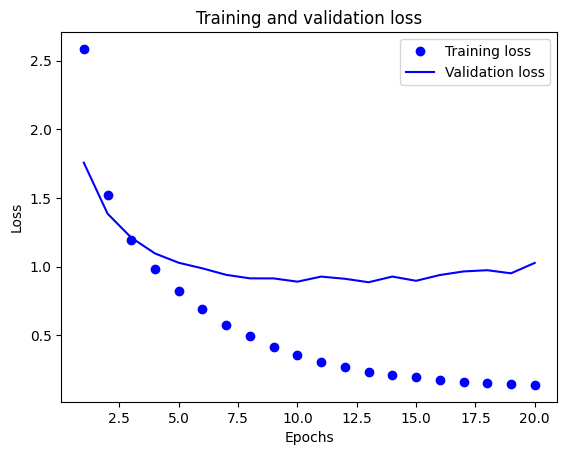

In [8]:
# PLotting the training and validation loss

import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

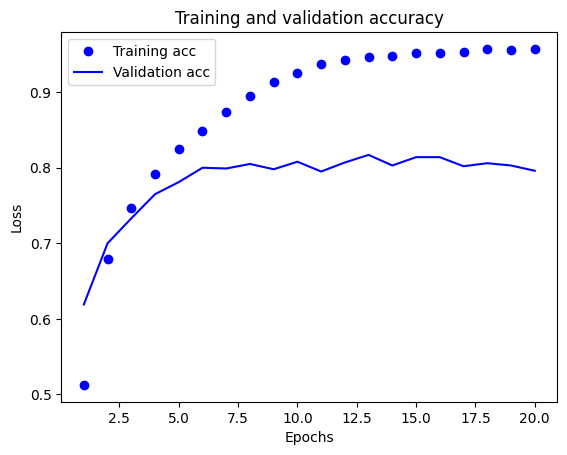

In [26]:
# Plotting the training and validation accuracy

plt.clf()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [14]:
# Retraining a model from scratch

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=9,
          batch_size=512,
          validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)

Epoch 1/9
16/16 [==============================] - 1s 34ms/step - loss: 2.8539 - accuracy: 0.4876 - val_loss: 2.0112 - val_accuracy: 0.5560
Epoch 2/9
16/16 [==============================] - 0s 17ms/step - loss: 1.7100 - accuracy: 0.6259 - val_loss: 1.4996 - val_accuracy: 0.6680
Epoch 3/9
16/16 [==============================] - 0s 19ms/step - loss: 1.3150 - accuracy: 0.7159 - val_loss: 1.2818 - val_accuracy: 0.7100
Epoch 4/9
16/16 [==============================] - 0s 19ms/step - loss: 1.0848 - accuracy: 0.7701 - val_loss: 1.1541 - val_accuracy: 0.7510
Epoch 5/9
16/16 [==============================] - 0s 16ms/step - loss: 0.9098 - accuracy: 0.8093 - val_loss: 1.0625 - val_accuracy: 0.7630
Epoch 6/9
16/16 [==============================] - 0s 17ms/step - loss: 0.7681 - accuracy: 0.8389 - val_loss: 0.9927 - val_accuracy: 0.7990
Epoch 7/9
16/16 [==============================] - 0s 17ms/step - loss: 0.6456 - accuracy: 0.8648 - val_loss: 0.9510 - val_accuracy: 0.8030
Epoch 8/9
16/16 [===

In [15]:
results

[0.9659835696220398, 0.7853962779045105]

In [16]:
# Generating predictions for new data

predictions = model.predict(x_test)

71/71 [==============================] - 0s 3ms/step


In [17]:
predictions[0].shape

(46,)

In [18]:
np.sum(predictions[0])

1.0000001

In [20]:
np.argmax(predictions[0])

3

In [24]:
# A model with an information bottleneck

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(4, activation='relu')) ######## AQUÍ HAY PÉRDIDA DE INFORMACIÓN YA QUE TENEMOS UN LAYER DE 4 DIMENSIONES
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)

print(results)

Epoch 1/20
63/63 [==============================] - 2s 10ms/step - loss: 3.1393 - accuracy: 0.3514 - val_loss: 2.5371 - val_accuracy: 0.3980
Epoch 2/20
63/63 [==============================] - 0s 6ms/step - loss: 2.2126 - accuracy: 0.4187 - val_loss: 2.0425 - val_accuracy: 0.4500
Epoch 3/20
63/63 [==============================] - 0s 6ms/step - loss: 1.7557 - accuracy: 0.4997 - val_loss: 1.6180 - val_accuracy: 0.6030
Epoch 4/20
63/63 [==============================] - 0s 6ms/step - loss: 1.3825 - accuracy: 0.6527 - val_loss: 1.4417 - val_accuracy: 0.6260
Epoch 5/20
63/63 [==============================] - 0s 6ms/step - loss: 1.2418 - accuracy: 0.6684 - val_loss: 1.4155 - val_accuracy: 0.6550
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 1.1553 - accuracy: 0.6919 - val_loss: 1.3960 - val_accuracy: 0.6700
Epoch 7/20
63/63 [==============================] - 0s 6ms/step - loss: 1.0872 - accuracy: 0.7169 - val_loss: 1.4164 - val_accuracy: 0.6760
Epoch 8/20
63/63 [=

# Predicting house prices: a regression example

## The Boston Housing Price dataset

In [29]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

print("train_data", train_data.shape)
print("test_data", test_data.shape)

train_data (404, 13)
test_data (102, 13)


In [30]:
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

In [32]:
# Normalizing the data

mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

In [33]:
# Model definition

from keras import models
from keras import layers

def build_model():
  model = models.Sequential()
  model.add(layers.Dense(64, activation='relu',
                         input_shape=(train_data.shape[1],)))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(1))
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  return model

In [34]:
# K-fold validation

import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
  print('processing fold #', i)
  val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples] ### preparar los datos de validación: datos de la partición #k
  val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

partial_train_data = np.concatenate(  ### preparar los datos de entrenamiento: datos de todas las otras particiones
    [train_data[:i * num_val_samples],
     train_data[(i + 1) * num_val_samples:]],
    axis=0)

partial_train_targets = np.concatenate(
    [train_targets[:i * num_val_samples],
     train_targets[(i + 1) * num_val_samples:]],
    axis=0)

model = build_model() ### construir el modelo Keras ya compilado
model.fit(partial_train_data, partial_train_targets, ### entrenar el modelo en silencio (verbose = 0)
          epochs=num_epochs, batch_size=1, verbose=0)
val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [35]:
all_scores

[2.7594845294952393]

In [36]:
np.mean(all_scores)

2.7594845294952393

In [39]:
# Saving the validation logs at each fold

num_epochs = 500
all_mae_histories = []
for i in range(k):
  print('processing fold #', i)
  val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

partial_train_data = np.concatenate(
    [train_data[:i * num_val_samples],
     train_data[(i + 1) * num_val_samples:]],
    axis=0)

partial_train_targets = np.concatenate(
    [train_targets[:i * num_val_samples],
     train_targets[(i + 1) * num_val_samples:]],
    axis=0)

model = build_model()
history = model.fit(partial_train_data, partial_train_targets,
                    validation_data=(val_data, val_targets),
                    epochs=num_epochs, batch_size=1, verbose=0)
mae_history = history.history['val_mean_absolute_error']
all_mae_histories.append(mae_history)



processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


KeyboardInterrupt: 

In [40]:
# Building the history of successive mean K-fold validation scores

average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [ ]:
# Plotting validation scores

import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()